In [ ]:
#DATE: 17/06/2021

##Review Based Sentiment Analysis Using GRU Deep Neural Network





mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#importing necessary libraries

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# reading dataset

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding = 'latin',names = ['sentiment','id','date','query','user','reviews'])
dataset.sample(n = 5)

,sentiment,id,date,query,user,reviews
865355,4,1677444498,Sat May 02 02:06:30 PDT 2009,NO_QUERY,SarahSaner,@ladybug8320 It definately is Perfectly put. xx
1557264,4,2185557285,Mon Jun 15 17:33:36 PDT 2009,NO_QUERY,cmlipe,@Chelzbellz Can't wait! I could use a nice esc...
6202,0,1469334883,Tue Apr 07 06:03:08 PDT 2009,NO_QUERY,stephchangry,i hate being the first one in and the last one...
1454398,4,2063322149,Sun Jun 07 02:11:45 PDT 2009,NO_QUERY,Lindscrafter,Should be sleeping....but im still awake.
38892,0,1573390450,Tue Apr 21 00:57:14 PDT 2009,NO_QUERY,WHETO666,"life is an ilusion , love is a dream but i d..."


# dataset details

In [ ]:
print('lenght of data is', len(dataset))
print("dataset shape is ", dataset.shape)

lenght of data is 1600000
dataset shape is  (1600000, 6)


In [ ]:
print("dataset information ", dataset.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   reviews    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
dataset information  None


# selecting only required columns

In [ ]:
dataset=dataset[['reviews','sentiment']]

In [ ]:
dataset['sentiment'][dataset['sentiment']==4]=1  # changing sntiment value 4 to 1

In [ ]:
dataset.sample(n = 5)

,reviews,sentiment
772497,"@mhcranberry i read that article on votto, not...",0
1413197,@artemisrex ha. Good to know.,1
89997,"4 hours of sleep all wkend? in Providence, RI",0
212400,@benshephard Diversity may have it based on UK...,0
970480,oof too many oreos ohmigosh. i'll save those o...,1


#preprocessing of reviews

In [ ]:
# remove urls, handles, and the hashtag
def remove_urls(text):
    new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    return new_text
# make all text lowercase
def text_lowercase(text):
    return text.lower()
# remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result
# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
# tokenize
def tokenize(text):
    text = word_tokenize(text)
    return text
# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    text = [i for i in text if not i in stop_words]
    return text

def preprocessing(text):
    text = text_lowercase(text)
    text = remove_urls(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = ' '.join(text)
    return text

In [ ]:
#applying preprocessing function
dataset['reviews']=dataset['reviews'].apply(lambda text: preprocessing(text))

In [ ]:
dataset.head(5)

,reviews,sentiment
0,awww bummer shoulda got david carr third day,0
1,upset update facebook texting might cry result...,0
2,dived many times ball managed save rest go bounds,0
3,whole body feels itchy like fire,0
4,behaving mad see,0


## removal of frequently occurred words

In [ ]:
cnt = Counter()
for text in dataset['reviews'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('good', 91340),
 ('day', 89731),
 ('get', 82160),
 ('like', 78579),
 ('go', 73986),
 ('quot', 72085),
 ('got', 70741),
 ('today', 68221),
 ('work', 64950),
 ('love', 64852)]

In [ ]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

dataset["reviews"] = dataset["reviews"].apply(lambda text: remove_freqwords(text))
dataset.head()

,reviews,sentiment
0,awww bummer shoulda david carr third,0
1,upset update facebook texting might cry result...,0
2,dived many times ball managed save rest bounds,0
3,whole body feels itchy fire,0
4,behaving mad see,0


In [ ]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

dataset["reviews"] = dataset["reviews"].apply(lambda text: remove_rarewords(text))
dataset.head()

,reviews,sentiment
0,awww bummer shoulda david carr third,0
1,upset update facebook texting might cry result...,0
2,dived many times ball managed save rest bounds,0
3,whole body feels itchy fire,0
4,behaving mad see,0


## Applying stemming

In [ ]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

dataset["reviews"] = dataset["reviews"].apply(lambda text: stem_words(text))

In [ ]:
dataset['reviews'].head()

0                 awww bummer shoulda david carr third
1    upset updat facebook text might cri result sch...
2            dive mani time ball manag save rest bound
3                           whole bodi feel itchi fire
4                                        behav mad see
Name: reviews, dtype: object

## applying lemmatization

In [ ]:
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(text):
    reviews = [lm.lemmatize(word) for word in dataset]
    return text

dataset['reviews'] = dataset['reviews'].apply(lambda x: lemmatizer_on_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
dataset['reviews'].head()

0                 awww bummer shoulda david carr third
1    upset updat facebook text might cri result sch...
2            dive mani time ball manag save rest bound
3                           whole bodi feel itchi fire
4                                        behav mad see
Name: reviews, dtype: object


#data after preprocessing

In [ ]:
dataset.sample(n = 5)

,reviews,sentiment
474739,say goodby cowork week least coupl come back fall,0
798396,want maldiv,0
932662,hi big fan r u greet bangladesh,1
1527332,salli amp laura make ice cream later meantim c...,1
731169,damnz feel chicken wing,0


bar graph plot

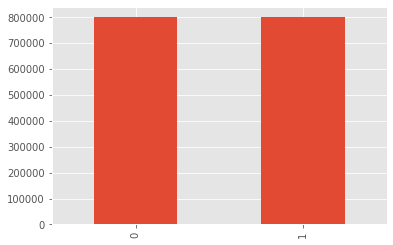

In [ ]:
dataset['sentiment'].value_counts().sort_index().plot.bar()

dividing dataset

In [ ]:
X=dataset.reviews[700000:1600000]
Y=dataset.sentiment[700000:1600000]

In [ ]:
max_len = 500 # max length of the reviews
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
print(sequences_matrix )

[[   0    0    0 ... 1227 1593 1884]
 [   0    0    0 ...  455 1269  609]
 [   0    0    0 ...  211   48   87]
 ...
 [   0    0    0 ...  110  234 1180]
 [   0    0    0 ...  121  655    3]
 [   0    0    0 ...    0    0   25]]


In [ ]:
sequences_matrix.shape

(900000, 500)

spliting of the dataset into 80:20 frame

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, Y, test_size=0.2, random_state=500)

In [ ]:
X_train.shape, Y_train.shape

((720000, 500), (720000,))

In [ ]:
X_test.shape, Y_test.shape

((180000, 500), (180000,))

# building LSTM model

In [ ]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) 
    return model



In [ ]:
model1 = tensorflow_based_model() 
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])  

In [ ]:
print(model1.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 50)           100000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

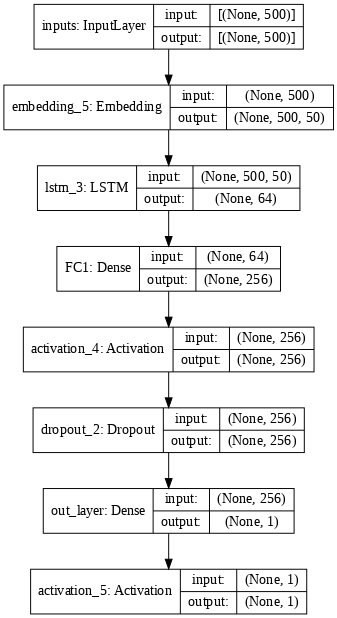

In [ ]:
plot_model(model1, to_file='MODEL.png',show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True, dpi= 70)

In [ ]:
model1.fit(X_train,Y_train,batch_size=128,epochs=5, validation_split=0.1)
print('Training finished !!')

Epoch 1/5
5063/5063 [==============================] - 166s 32ms/step - loss: 0.2686 - accuracy: 0.9019 - val_loss: 0.2624 - val_accuracy: 0.9021
Epoch 2/5
5063/5063 [==============================] - 160s 32ms/step - loss: 0.2567 - accuracy: 0.9052 - val_loss: 0.2604 - val_accuracy: 0.9034
Epoch 3/5
5063/5063 [==============================] - 160s 32ms/step - loss: 0.2527 - accuracy: 0.9067 - val_loss: 0.2597 - val_accuracy: 0.9033
Epoch 4/5
5063/5063 [==============================] - 160s 32ms/step - loss: 0.2493 - accuracy: 0.9074 - val_loss: 0.2598 - val_accuracy: 0.9037
Epoch 5/5
5063/5063 [==============================] - 159s 31ms/step - loss: 0.2457 - accuracy: 0.9089 - val_loss: 0.2589 - val_accuracy: 0.9043
Training finished !!


In [ ]:
history = model1.history.history

In [ ]:
for key in history.keys():
  print(key)


loss
accuracy
val_loss
val_accuracy


In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

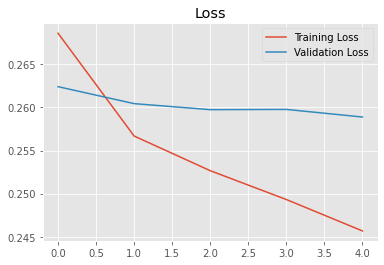

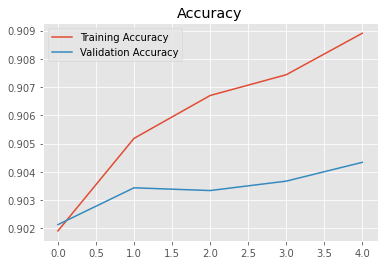

In [ ]:
plot_metrics(history)

In [ ]:
accr = model1.evaluate(X_test,Y_test) 

5625/5625 [==============================] - 50s 9ms/step - loss: 0.2547 - accuracy: 0.9058


In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr[1]))

Test set
  Accuracy: 0.91


In [ ]:
y_pred = model1.predict(X_test) 
y_pred = (y_pred > 0.5) 

 confusion matrix for LSTM

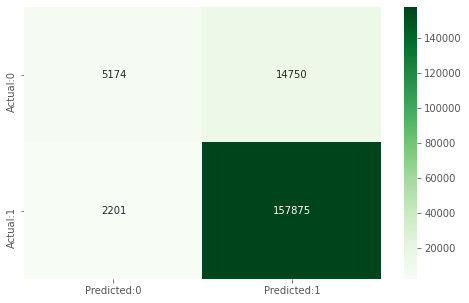

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.70      0.26      0.38     19924
           1       0.91      0.99      0.95    160076

    accuracy                           0.91    180000
   macro avg       0.81      0.62      0.66    180000
weighted avg       0.89      0.91      0.89    180000



In [ ]:
cm = confusion_matrix(Y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted:0', 'Predicted:1'], 
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Greens")
plt.show()
  
print('The details for confusion matrix is =')
print (classification_report(Y_test, y_pred))

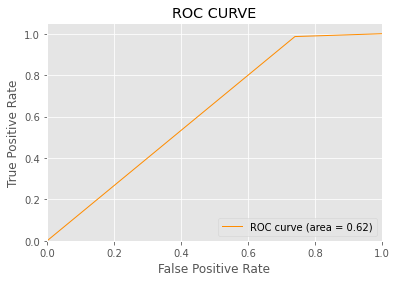

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# building GRU model

In [ ]:
# required libraries for gru
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, GRU, Flatten
from keras.layers.embeddings import Embedding

In [ ]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

model = Sequential()
model.add(Embedding(2000,50,input_length=max_words))
model.add(GRU(100))
model.add(Dense(1, activation='tanh'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 50)           100000    
_________________________________________________________________
gru_5 (GRU)                  (None, 100)               45600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 145,701
Trainable params: 145,701
Non-trainable params: 0
_________________________________________________________________


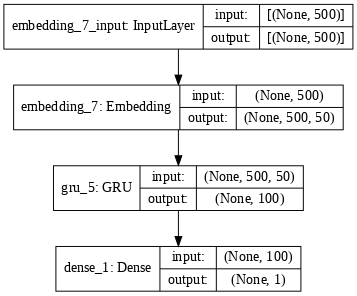

In [ ]:
plot_model(model, to_file='MODEL.png',show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True, dpi= 70)

In [ ]:
model.fit(X_train, Y_train, epochs=5, batch_size=128,validation_split=0.1) 


Epoch 1/5
5063/5063 [==============================] - 195s 36ms/step - loss: 0.3380 - accuracy: 0.8784 - val_loss: 0.2643 - val_accuracy: 0.9023
Epoch 2/5
5063/5063 [==============================] - 183s 36ms/step - loss: 0.2596 - accuracy: 0.9036 - val_loss: 0.2687 - val_accuracy: 0.8970
Epoch 3/5
5063/5063 [==============================] - 181s 36ms/step - loss: 0.2538 - accuracy: 0.9059 - val_loss: 0.2616 - val_accuracy: 0.9031
Epoch 4/5
5063/5063 [==============================] - 179s 35ms/step - loss: 0.2498 - accuracy: 0.9070 - val_loss: 0.2642 - val_accuracy: 0.9031
Epoch 5/5
5063/5063 [==============================] - 181s 36ms/step - loss: 0.2466 - accuracy: 0.9086 - val_loss: 0.2632 - val_accuracy: 0.9027


In [ ]:
history=model.history.history

In [ ]:
for key in history.keys():
  print(key)


loss
accuracy
val_loss
val_accuracy


In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

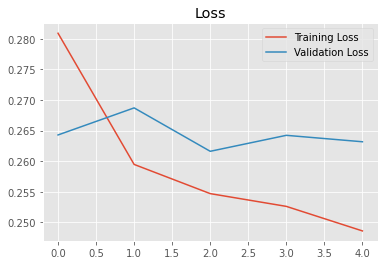

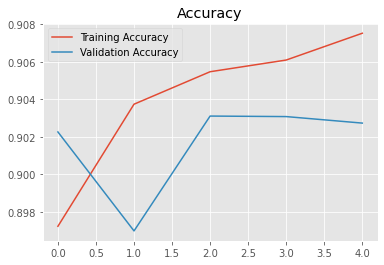

In [ ]:
plot_metrics(history)

In [ ]:
acc = model.evaluate(X_test,Y_test) 

5625/5625 [==============================] - 47s 8ms/step - loss: 0.2571 - accuracy: 0.9060


In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr[1]))

Test set
  Accuracy: 0.91


In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) 

confusion_matrix

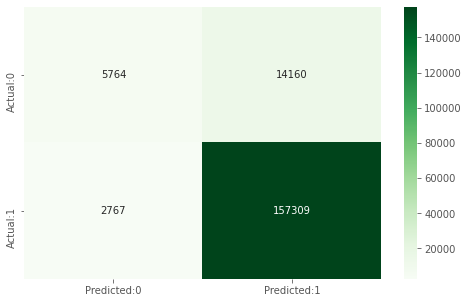

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.68      0.29      0.41     19924
           1       0.92      0.98      0.95    160076

    accuracy                           0.91    180000
   macro avg       0.80      0.64      0.68    180000
weighted avg       0.89      0.91      0.89    180000



In [ ]:
cm = confusion_matrix(Y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted:0', 'Predicted:1'], 
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Greens")
plt.show()
  
print('The details for confusion matrix is =')
print (classification_report(Y_test, y_pred))

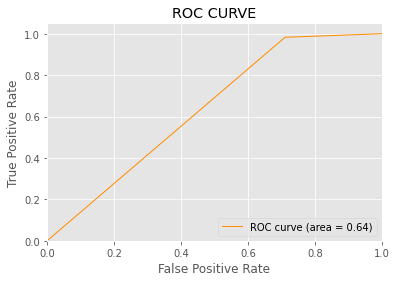

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()